In [1]:
import numpy as np
import torch
from torch import nn
import cv2
import kornia
from matplotlib import pyplot as plt

import sys
sys.path.insert(0, '../research_pipelines/denoising_with_fourier/FFTCNN/')
sys.path.insert(0, '../research_pipelines/denoising_with_fourier/')
from torch_resample import resample

from attention import WindowBasedSelfAttention

%matplotlib inline

In [2]:
def read_image(_imgp):
    _img = cv2.imread(_imgp, cv2.IMREAD_COLOR)
    _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
    return _img


def retrieve_elements_from_indices(tensor, indices):
    flattened_tensor = tensor.flatten(start_dim=2)
    output = flattened_tensor.gather(dim=2, index=indices.flatten(start_dim=2)).view_as(indices)
    return output


class FFTMaxPool(nn.Module):
    def __init__(self, k: int = 2):
        super().__init__()
        self.k = k

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        x = torch.abs(z)
        _, indices = nn.functional.max_pool2d_with_indices(x, kernel_size=self.k)
        new_y = retrieve_elements_from_indices(z, indices)

        return new_y, indices
    
    
class FFTUnpool(nn.Module):
    def __init__(self, k: int = 2) -> None:
        super().__init__()
        self.k = k

    def forward(self, x, indices):
        x_re = x.real
        x_im = x.imag
        
        new_y_re = nn.functional.max_unpool2d(x_re, indices, self.k)
        new_y_im = nn.functional.max_unpool2d(x_im, indices, self.k)
        
        return new_y_re + 1.0j * new_y_im
    
    
class FFTDownsample(nn.Module):
    def __init__(self, k: int = 2) -> None:
        super().__init__()
        self.k = k

    def forward(self, z):
        new_y = z[:, :, ::self.k, ::self.k]
        return new_y
    
    
class FFTUpsample(nn.Module):
    def __init__(self, k: int = 2) -> None:
        super().__init__()
        self.k = k

    def forward(self, x):
        h_in, w_in = x.size(2), x.size(3)
        h = h_in * self.k
        w = w_in * self.k
        
        new_y = torch.zeros(x.size(0), x.size(1), h, w, dtype=x.dtype, device=x.device)
        
        new_y[:, :, ::self.k, ::self.k] = x
        
        return new_y
    
    
class SpectralPad(nn.Module):
    def __init__(self, k: int = 2) -> None:
        super().__init__()
        self.k = k

    def forward(self, x):
        h_in, w_in = x.size(2), x.size(3)
        h = h_in * self.k
        w = w_in * self.k
        k = self.k
        
        new_y = torch.zeros(x.size(0), x.size(1), h, w, dtype=x.dtype, device=x.device)
        
        for i in range(-h_in // 2, h_in // 2):
            for j in range(-w_in // 2, w_in // 2):
                new_y[:, :, h // 2 + i*k, w // 2 + j*k] = \
                    x[:, :, h_in // 2 + i, w_in // 2 + j]

        return new_y * self.k
    

def generate_batt(size=(5, 5), d0=5, n=2):
    kernel = np.fromfunction(
        lambda x, y: \
            1 / (1 + (((x - size[0] // 2) ** 2 + (
                    y - size[1] // 2) ** 2) ** 1 / 2) / d0) ** n,
        (size[0], size[1])
    )
    return kernel

    
class HightFrequencyImageComponent(nn.Module):
    def __init__(self, shape, four_normalized=True):
        super().__init__()

        self.four_normalized = four_normalized
        kernel = 1.0 - generate_batt(shape, 500, 1).astype(np.float32)
        self.image_shape = shape

        kernel = torch.from_numpy(kernel).unsqueeze(0).unsqueeze(0)
        kernel = kernel.to(torch.cfloat)
        
        self.kernel = nn.Parameter(kernel, requires_grad=False)

    def apply_fft_kernel(self, x):
        return x*self.kernel[:, -x.size(2):]

    def forward(self, z):
        n_fourier_transform_x = self.apply_fft_kernel(
            torch.fft.fftshift(z)
        )
        return torch.fft.ifftshift(n_fourier_transform_x)
    
    
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]], dtype=np.float32)
    _ycbcr = im.dot(xform.T)
    _ycbcr[:,:,[1,2]] += 128 / 255.0
    return _ycbcr


def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]], dtype=np.float32)
    _rgb = im.astype(np.float32)
    _rgb[:,:,[1,2]] -= 128 / 255.0
    _rgb = _rgb.dot(xform.T)
    return _rgb


class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted
    
    
class ComplexSelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(ComplexSelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim, dtype=torch.cfloat)
        self.key = nn.Linear(input_dim, input_dim, dtype=torch.cfloat)
        self.value = nn.Linear(input_dim, input_dim, dtype=torch.cfloat)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(torch.abs(scores)).to(torch.cfloat)
        weighted = torch.bmm(attention, values)
        return weighted
    

def get_fft_scale_shift(crop_z, scale: int, shift: tuple):
    x0, y0 = shift

    new_z = SpectralPad(scale)(crop_z)
    
    zh = new_z.size(2)
    zw = new_z.size(3)
    
    xF, yF = torch.meshgrid(torch.arange(-zh//2, zh//2), torch.arange(-zw//2, zw//2))

    xF = xF.unsqueeze(0).unsqueeze(0)
    yF = yF.unsqueeze(0).unsqueeze(0)

    new_z = new_z * torch.exp(-1.0j*2*torch.pi*(xF*x0 + yF*y0) / zh)
    return new_z

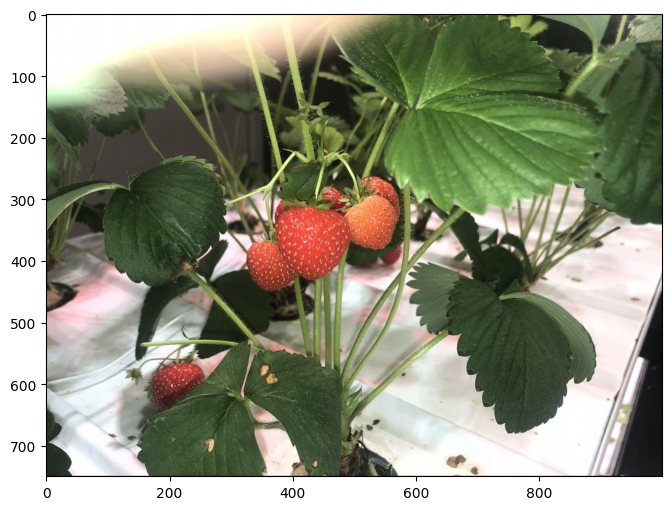

In [133]:
image_path = '/Users/alexey/Downloads/st_photo_1.jpg'
# image_path = '../materials/sony_a7c_5_crop.png'
image = read_image(image_path)
l_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)[..., 0]

plt.figure(figsize=(8, 6))
plt.imshow(image, 'gray')

plt.show()

In [18]:
rgb = torch.from_numpy(read_image(image_path).astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0)

ycrcbt = kornia.color.ycbcr.rgb_to_ycbcr(rgb)
rgb_t = kornia.color.ycbcr.ycbcr_to_rgb(ycrcbt)

print((rgb_t - rgb).mean())

# plt.figure(figsize=(8, 6))
# plt.imshow(rgb2, 'gray')

# plt.show()

tensor(-3.8562e-06)


286.37416167364586


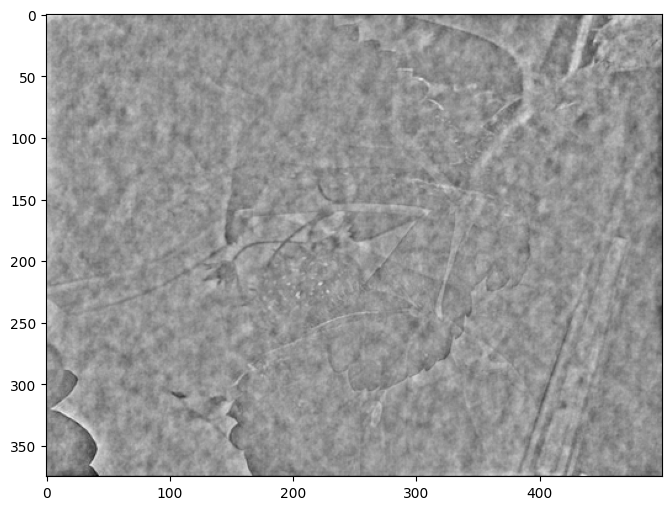

In [134]:
img_fft = np.fft.fft2(l_image - 0.5).astype(np.cfloat)
t_tensor = torch.from_numpy(img_fft).to(torch.cfloat)
t_tensor = t_tensor.unsqueeze(0).unsqueeze(0)

t_tensor = HightFrequencyImageComponent((l_image.shape[:2]))(t_tensor)

downscale_t, indices = FFTMaxPool(2)(t_tensor)
downscale_img_fft = downscale_t.squeeze(0).squeeze(0).numpy()
downscale_image = np.fft.ifft2(downscale_img_fft)
downscale_image = downscale_image.real + 0.5
print(downscale_image.max())

plt.figure(figsize=(8, 6))
plt.imshow(downscale_image, 'gray')

plt.show()

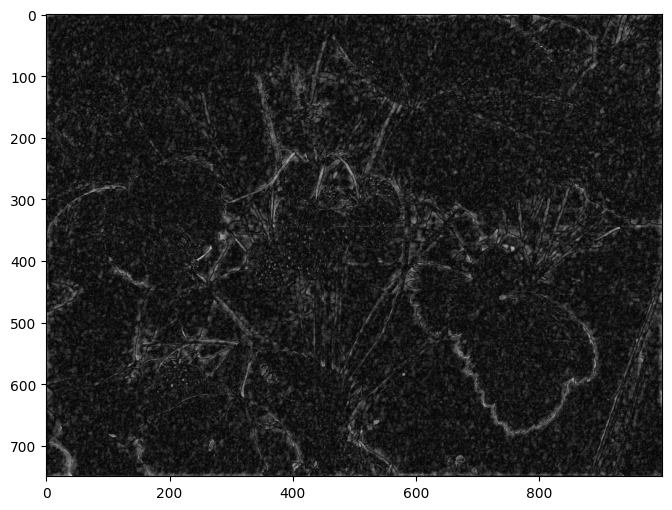

In [135]:
t_tensor = torch.clone(downscale_t).to(torch.cfloat)

upscale_t = FFTUnpool(2)(t_tensor, indices)
upscale_img_fft = upscale_t.squeeze(0).squeeze(0).numpy()
upscale_image = np.abs(np.fft.ifft2(upscale_img_fft))

plt.figure(figsize=(8, 6))
plt.imshow(upscale_image, 'gray')

plt.show()

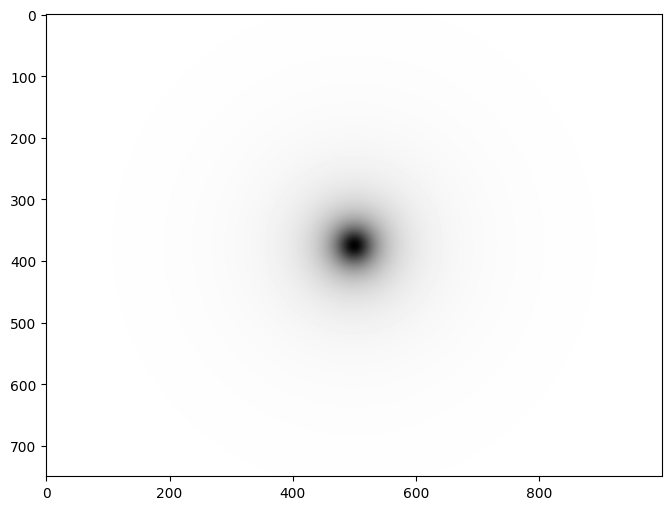

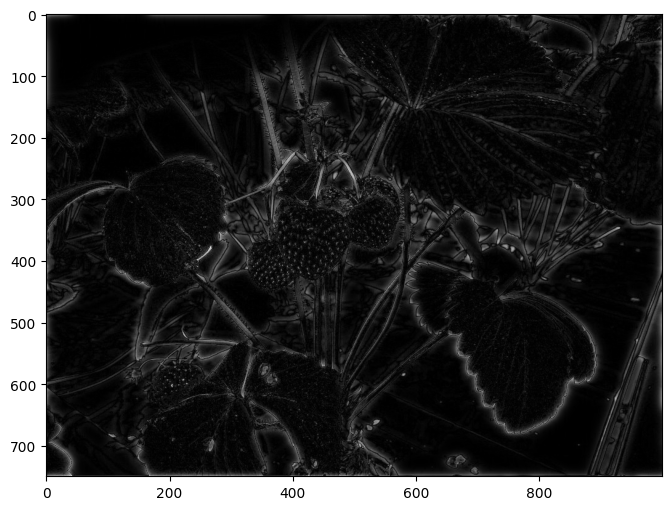

In [136]:
hf = HightFrequencyImageComponent((l_image.shape[:2]))

img_fft = np.fft.fft2(l_image)
t_tensor = torch.from_numpy(img_fft)
t_tensor = t_tensor.unsqueeze(0).unsqueeze(0)

f_tensor = hf(t_tensor)

filteted_img_fft = f_tensor.squeeze(0).squeeze(0).numpy()
filteted_image = np.abs(np.fft.ifft2(filteted_img_fft))


plt.figure(figsize=(8, 6))
plt.imshow(torch.abs(hf.kernel[0, 0]), 'gray')

plt.figure(figsize=(8, 6))
plt.imshow(filteted_image, 'gray')

plt.show()

In [148]:
rgb_tensor = torch.from_numpy(image[:64, :64].astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0)
rgb_tensor.shape

torch.Size([1, 3, 64, 64])

torch.Size([1, 3, 9, 9, 8, 8])
torch.Size([1, 243, 64])
torch.Size([1, 3, 9, 9, 8, 8])


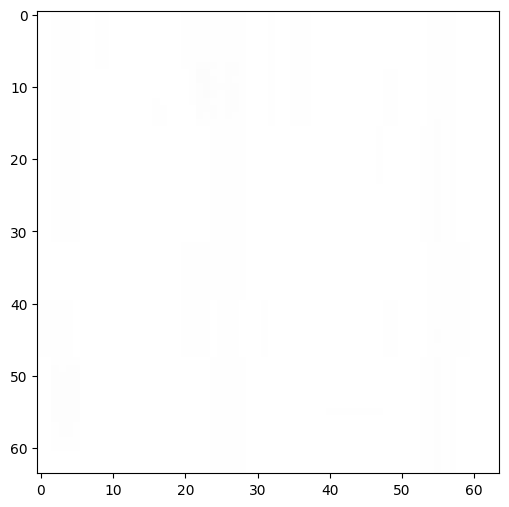

In [149]:
path_size = 8

p = rgb_tensor.unfold(
    2, size=path_size, step=7 * path_size // 8
).unfold(3, path_size, step=7 * path_size // 8).contiguous()

fftp = torch.fft.fft2(p)
fftp = torch.fft.fftshift(fftp)

init_p_shape = p.shape

p = fftp

print(init_p_shape)

p = p.view(
    p.size(0), 
    p.size(1) * p.size(2) * p.size(3),
    p.size(4) * p.size(5)
)

print(p.shape)

sattn = ComplexSelfAttention(path_size ** 2)

# out = p * torch.sigmoid(sattn(p))
out = p

out = out.view(*init_p_shape)

out = torch.fft.ifftshift(out)
out = torch.fft.ifft2(out).real

res = torch.zeros_like(rgb_tensor)
mask = torch.zeros(rgb_tensor.size(0), 1, rgb_tensor.size(2), rgb_tensor.size(3)).to(torch.float32)

print(out.shape)

for i in range(out.size(2)):
    for j in range(out.size(3)):
        i_coord = i * 7 * path_size // 8
        j_coord = j * 7 * path_size // 8
        
        res[:, :, i_coord:i_coord+path_size, j_coord:j_coord+path_size] += out[:, :, i, j]
        mask[:, :, i_coord:i_coord+path_size, j_coord:j_coord+path_size] += 1
        
out = res / mask

# corners = out[:, :, ::2, ::2]
# anchors = out[:, :, 1::2, 1::2]

# print(corners.shape, anchors.shape)

# 0 1 2 3 4 5 6
# % o % o % o %
# 0   1   2   3
#   0   1   2


# corners[:, :, :-1, :-1, path_size//2:, path_size//2:] = \
#                                         corners[:, :, :-1, :-1, path_size//2:, path_size//2:] / 2 + \
#                                         anchors[:, :, :, :, :path_size//2, :path_size//2] / 2

# corners[:, :, :-1, 1:, path_size//2:, :path_size//2] = \
#                                         corners[:, :, :-1, 1:, path_size//2:, :path_size//2] / 2 + \
#                                         anchors[:, :, :, :, :path_size//2, path_size//2:] / 2

# corners[:, :, 1:, :-1, :path_size//2, path_size//2:] = \
#                                         corners[:, :, 1:, :-1, :path_size//2, path_size//2:] / 2 + \
#                                         anchors[:, :, :, :, path_size//2:, :path_size//2] / 2

# corners[:, :, 1:, 1:, :path_size//2, :path_size//2] = \
#                                         corners[:, :, 1:, 1:, :path_size//2, :path_size//2] / 2 + \
#                                         anchors[:, :, :, :, path_size//2:, path_size//2:] / 2


# out = corners
# out = torch.cat([out[:, :, :, i] for i in range(out.size(3))], dim=4)
# out = torch.cat([out[:, :, i] for i in range(out.size(2))], dim=2)

# print(out.shape)

plt.figure(figsize=(8, 6))
plt.imshow(out.detach()[0].permute(1, 2, 0).numpy().clip(0, 1))

plt.show()

In [11]:
llayer = nn.Linear(1024, 64)

llayer(torch.rand(1, 384, 1024)).shape

torch.Size([1, 384, 64])

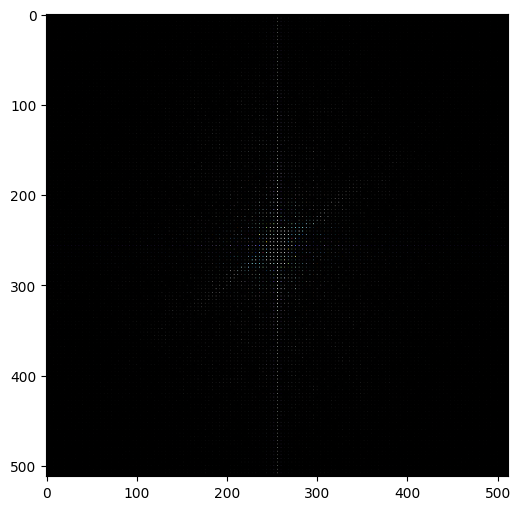

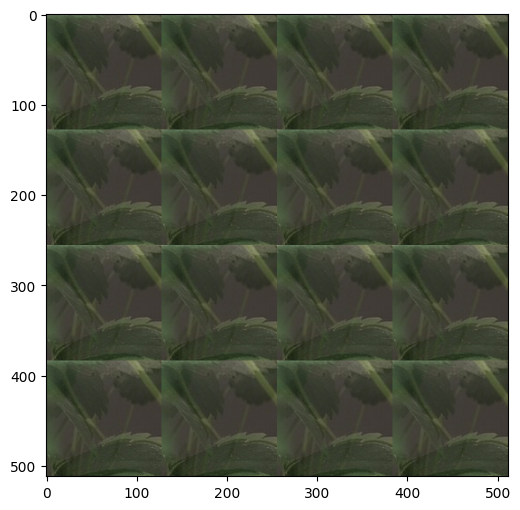

In [113]:
crop1 = rgb_tensor[:, :, 0:128, 0:128]
crop2 = rgb_tensor[:, :, 0:128, 128:256]

filter1 = torch.zeros_like(rgb_tensor)
filter1[:, :, 0:128, 0:128] = 1
filter1 = 1.0 - filter1

filter2 = torch.zeros_like(rgb_tensor)
filter2[:, :, 0:128, 128:256] = 1
filter2 = 1.0 - filter2

z1 = torch.fft.fft2(crop1, norm='ortho')
z1 = torch.fft.fftshift(z1)

z2 = torch.fft.fft2(crop2, norm='ortho')
z2 = torch.fft.fftshift(z2)

f1 = torch.fft.fft2(filter1, norm='ortho')
f1 = torch.fft.fftshift(f1)

f2 = torch.fft.fft2(filter2, norm='ortho')
f2 = torch.fft.fftshift(f2)

z1 = get_fft_scale_shift(z1, 4, (0, 0))
z2 = get_fft_scale_shift(z2, 4, (0, 128))

z = torch.stack((z1, z2), dim=0)
_, max_indices = torch.max(torch.abs(z), dim=0, keepdim=True)
z = retrieve_elements_from_indices(z, max_indices)[0]
z = z1 / 2 + z2 / 2


plt.figure(figsize=(8, 6))
plt.imshow(torch.abs(z)[0].permute(1, 2, 0).numpy().clip(0, 1))

z = torch.fft.ifftshift(z)
x1 = torch.fft.ifft2(z, norm='ortho').real

plt.figure(figsize=(8, 6))
plt.imshow(x1[0].permute(1, 2, 0).numpy().clip(0, 1))

plt.show()

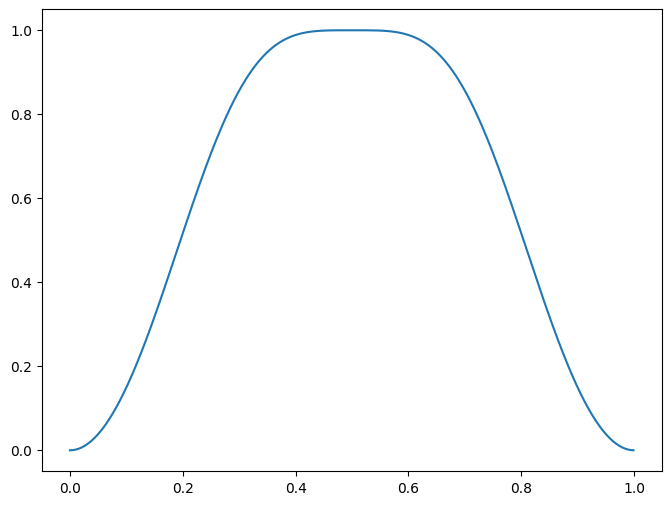

In [50]:
f = lambda x: np.sin( np.sin(np.pi * x) ** 2 * np.pi/2 )

x = np.arange(0, 1, 0.001)
y = f(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.show()